In [14]:
import os
import random
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pandas as pd
from scipy.linalg import cho_solve, cho_factor
import gpytorch
from datetime import datetime
import torch
from scipy.linalg import cholesky,solve_triangular
import random
from scipy.optimize import minimize

In [15]:
appl_data_df = pd.read_csv("APPL.csv")
appl_data_df.head()

,Date,Open,High,Low,Close,Volume
0,06/27/2024,214.69,215.74,212.35,214.10,"49,772,711"
1,06/26/2024,211.50,214.86,210.64,213.25,"66,213,195"
2,06/25/2024,209.15,211.38,208.61,209.07,"56,713,871"
3,06/24/2024,207.72,212.70,206.59,208.14,"80,727,008"
4,06/21/2024,210.39,211.89,207.11,207.49,"246,421,406"


In [16]:
# Convert the 'Date' column to datetime
appl_data_df['Date'] = pd.to_datetime(appl_data_df['Date'], format='%m/%d/%Y')

# Format the 'Date' column to 'yyyy-mm-dd'
appl_data_df['Date'] = appl_data_df['Date'].dt.strftime('%Y-%m-%d')

appl_data_df.head()

,Date,Open,High,Low,Close,Volume
0,2024-06-27,214.69,215.74,212.35,214.10,"49,772,711"
1,2024-06-26,211.50,214.86,210.64,213.25,"66,213,195"
2,2024-06-25,209.15,211.38,208.61,209.07,"56,713,871"
3,2024-06-24,207.72,212.70,206.59,208.14,"80,727,008"
4,2024-06-21,210.39,211.89,207.11,207.49,"246,421,406"


In [17]:
model_df = appl_data_df.copy()

In [18]:
model_df = model_df.sort_values(by='Date').reset_index(drop=True)

In [19]:
def calculate_and_update_macd(df, short_window=12, long_window=26, signal_window=9):
    """
    Calculate MACD, Signal line, and Histogram, and update the DataFrame with these values.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data with 'Date' and 'Close' columns.
    short_window (int): The short period for the fast EMA (default is 12).
    long_window (int): The long period for the slow EMA (default is 26).
    signal_window (int): The period for the signal line EMA (default is 9).

    Returns:
    pd.DataFrame: The original DataFrame updated with 'MACD', 'Signal', and 'Histogram' columns.
    """
    # Ensure the 'Date' column is in datetime format
    #df['Date'] = pd.to_datetime(df['Date'])

    # Calculate the short period EMA
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()

    # Calculate the long period EMA
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()

    # Calculate the MACD line
    df['MACD'] = df['EMA_short'] - df['EMA_long']

    # Calculate the Signal line
    df['Signal'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    # Calculate the MACD Histogram
    df['Histogram'] = df['MACD'] - df['Signal']

    # Drop the temporary EMA columns
    df.drop(columns=['EMA_short', 'EMA_long'], inplace=True)

    return df

In [20]:
model_df = calculate_and_update_macd(model_df)
model_df.tail()

,Date,Open,High,Low,Close,Volume,MACD,Signal,Histogram
248,2024-06-21,210.39,211.89,207.11,207.49,"246,421,406",7.349035,6.878425,0.470609
249,2024-06-24,207.72,212.70,206.59,208.14,"80,727,008",6.923191,6.887379,0.035812
250,2024-06-25,209.15,211.38,208.61,209.07,"56,713,871",6.584844,6.826872,-0.242028
251,2024-06-26,211.50,214.86,210.64,213.25,"66,213,195",6.578164,6.777130,-0.198966
252,2024-06-27,214.69,215.74,212.35,214.10,"49,772,711",6.565771,6.734858,-0.169087


In [21]:
model_df['Volume'] = model_df['Volume'].str.replace(',', '').astype(float)

In [22]:
model2_df = model_df.copy()

In [23]:
def calculate_and_update_klinger(df, short_window=34, long_window=55, signal_window=13):
    # Ensure the 'Date' column is in datetime format
    #df['Date'] = pd.to_datetime(df['Date'])
    df['Trend'] = np.nan
    df['cm'] = np.nan
    df['dm'] = df['High'] - df['Low']
    for index, row in df.iterrows():
        if (index > 0):
            if (row['High']+row['Low']+row['Close']) > (df.at[index-1,'High'] + df.at[index-1,'Low'] + df.at[index-1,'Close']):
                df.at[index,'Trend'] = 1
            else:
                df.at[index,'Trend'] = -1
                
            if row['Trend'] == df.at[index-1,'Trend']:
                df.at[index,'cm'] = row['dm'] + df.at[index-1,'cm']
            else:
                df.at[index,'cm'] = row['dm'] + df.at[index-1,'dm']
                
        elif (index == 0):
            df.at[index,'cm'] = row['dm']
            df.at[index,'Trend'] = 0
    df['Volume_force'] = df['Volume']*(2*(df['dm']/df['cm'])-1)*df['Trend']*100
    
    # Calculate the short and long period EMAs of the volume force
    df['VF_short_ema'] = df['Volume_force'].ewm(span=short_window, adjust=False).mean()
    df['VF_long_ema'] = df['Volume_force'].ewm(span=long_window, adjust=False).mean()

    # Calculate the Klinger Oscillator
    df['KlingerOscillator'] = df['VF_short_ema'] - df['VF_long_ema']
    
    # Calculate the Signal Line
    df['SignalLine'] = df['KlingerOscillator'].ewm(span=signal_window, adjust=False).mean()
    df['Histogram2'] = df['KlingerOscillator'] - df['SignalLine']
    return df

In [24]:
model2_df = calculate_and_update_klinger(model2_df)
model2_df.tail(10)

,Date,Open,High,Low,Close,Volume,MACD,Signal,Histogram,Trend,cm,dm,Volume_force,VF_short_ema,VF_long_ema,KlingerOscillator,SignalLine,Histogram2
243,2024-06-13,214.74,216.75,211.60,214.24,97862727.0,6.881929,5.162951,1.718978,1.0,18.45,5.15,-4.322933e+09,7.942474e+07,1.310912e+08,-5.166646e+07,-2.367321e+07,-2.799324e+07
244,2024-06-14,213.85,215.17,211.30,212.49,70122750.0,7.344796,5.599320,1.745476,-1.0,9.02,3.87,9.950900e+08,1.317485e+08,1.619483e+08,-3.019983e+07,-2.460559e+07,-5.594241e+06
245,2024-06-17,213.37,218.95,212.72,216.67,93728305.0,7.957186,6.070893,1.886293,1.0,10.10,6.23,2.190087e+09,2.493678e+08,2.343818e+08,1.498599e+07,-1.894965e+07,3.393564e+07
246,2024-06-18,217.59,218.63,213.00,214.29,79943250.0,8.156442,6.488003,1.668439,-1.0,11.86,5.63,4.044347e+08,2.582288e+08,2.404551e+08,1.777364e+07,-1.370346e+07,3.147710e+07
247,2024-06-20,213.93,214.24,208.85,209.68,86172445.0,7.851853,6.760773,1.091080,-1.0,11.02,5.39,1.876714e+08,2.541969e+08,2.385700e+08,1.562692e+07,-9.513407e+06,2.514033e+07
248,2024-06-21,210.39,211.89,207.11,207.49,246421406.0,7.349035,6.878425,0.470609,-1.0,10.17,4.78,1.478044e+09,3.241310e+08,2.828369e+08,4.129411e+07,-2.255190e+06,4.354930e+07
249,2024-06-24,207.72,212.70,206.59,208.14,80727008.0,6.923191,6.887379,0.035812,1.0,10.89,6.11,9.859221e+08,3.619477e+08,3.079471e+08,5.400056e+07,5.781345e+06,4.821921e+07
250,2024-06-25,209.15,211.38,208.61,209.07,56713871.0,6.584844,6.826872,-0.242028,1.0,8.88,2.77,-2.133157e+09,2.193703e+08,2.207648e+08,-1.394559e+06,4.756216e+06,-6.150775e+06
251,2024-06-26,211.50,214.86,210.64,213.25,66213195.0,6.578164,6.777130,-0.198966,1.0,6.99,4.22,1.373521e+09,2.853218e+08,2.619347e+08,2.338705e+07,7.417764e+06,1.596929e+07
252,2024-06-27,214.69,215.74,212.35,214.10,49772711.0,6.565771,6.734858,-0.169087,1.0,7.61,3.39,-5.428561e+08,2.379973e+08,2.331922e+08,4.805132e+06,7.044531e+06,-2.239399e+06


In [12]:
model_train = model2_df[['Date','Close','Histogram','Histogram2']].copy()
model_train_subset = model_train[(model_train['Date'] >= '2024-01-01') & (model_train['Date'] < '2024-03-01')]
model_train_subset_test = model_train[(model_train['Date'] >= '2024-03-01') & (model_train['Date'] <= '2024-03-07')]
model_train_subset['Date'] = pd.to_datetime(model_train_subset['Date'])
model_train_subset['Date_ordinal'] = model_train_subset['Date'].apply(lambda x: x.toordinal())
model_train_subset_test['Date'] = pd.to_datetime(model_train_subset_test['Date'])
model_train_subset_test['Date_ordinal'] = model_train_subset_test['Date'].apply(lambda x: x.toordinal()) 
model_train_subset_test.head(10)

C:\Users\aman1\AppData\Local\Temp\ipykernel_18112\349981697.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_train_subset['Date'] = pd.to_datetime(model_train_subset['Date'])
C:\Users\aman1\AppData\Local\Temp\ipykernel_18112\349981697.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_train_subset['Date_ordinal'] = model_train_subset['Date'].apply(lambda x: x.toordinal())
C:\Users\aman1\AppData\Local\Temp\ipykernel_18112\349981697.py:6: SettingWithCopyWarning: 
A value is trying to be set on

,Date,Close,Histogram,Histogram2,Date_ordinal
171,2024-03-01,179.66,-0.346358,5.932277e+07,738946
172,2024-03-04,175.10,-0.625122,5.127532e+07,738949
173,2024-03-05,170.12,-1.067598,6.507080e+07,738950
174,2024-03-06,169.12,-1.333064,4.947725e+07,738951
175,2024-03-07,169.00,-1.414468,4.886872e+07,738952


In [25]:
model_train = model2_df[['Date','Close','Histogram','Histogram2']].copy()
model_train_subset = model_train[(model_train['Date'] >= '2024-01-01') & (model_train['Date'] < '2024-03-01')]
model_train_subset_test = model_train[(model_train['Date'] >= '2024-03-01') & (model_train['Date'] <= '2024-03-07')]
model_train_subset['Date'] = pd.to_datetime(model_train_subset['Date'])
model_train_subset['Date_ordinal'] = model_train_subset['Date'].apply(lambda x: x.toordinal())
model_train_subset_test['Date'] = pd.to_datetime(model_train_subset_test['Date'])
model_train_subset_test['Date_ordinal'] = model_train_subset_test['Date'].apply(lambda x: x.toordinal()) 
model_train_subset_test.head(10)

C:\Users\aman1\AppData\Local\Temp\ipykernel_18112\349981697.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_train_subset['Date'] = pd.to_datetime(model_train_subset['Date'])
C:\Users\aman1\AppData\Local\Temp\ipykernel_18112\349981697.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_train_subset['Date_ordinal'] = model_train_subset['Date'].apply(lambda x: x.toordinal())
C:\Users\aman1\AppData\Local\Temp\ipykernel_18112\349981697.py:6: SettingWithCopyWarning: 
A value is trying to be set on

,Date,Close,Histogram,Histogram2,Date_ordinal
171,2024-03-01,179.66,-0.346358,5.932277e+07,738946
172,2024-03-04,175.10,-0.625122,5.127532e+07,738949
173,2024-03-05,170.12,-1.067598,6.507080e+07,738950
174,2024-03-06,169.12,-1.333064,4.947725e+07,738951
175,2024-03-07,169.00,-1.414468,4.886872e+07,738952


In [26]:
model_train_final = model_train_subset.copy()
model_train_final_test = model_train_subset_test.copy()

mean = model_train_final['Date_ordinal'].mean()
std = model_train_final['Date_ordinal'].std()

model_train_final['Date_ordinal'] = (model_train_final['Date_ordinal'] - mean)/std
model_train_final_test['Date_ordinal'] = (model_train_final_test['Date_ordinal'] - mean)/std

X_train2 = model_train_final[['Date_ordinal', 'Histogram', 'Histogram2']].values
y_train2 = model_train_final['Close'].values

X_test2 = model_train_final_test[['Date_ordinal', 'Histogram', 'Histogram2']].values
y_test2 = model_train_final_test['Close'].values

In [27]:
model_train_final_test = model_train_final_test[['Date_ordinal', 'Histogram', 'Histogram2']].copy()
model_train_final_test['Histogram'] = model_train_final.iloc[-1]['Histogram']
model_train_final_test['Histogram2'] = model_train_final.iloc[-1]['Histogram2']

X_test2 = model_train_final_test[['Date_ordinal', 'Histogram', 'Histogram2']].values
X_test2

array([[ 1.70991909e+00, -3.11615024e-01,  7.28259018e+07],
       [ 1.88049496e+00, -3.11615024e-01,  7.28259018e+07],
       [ 1.93735359e+00, -3.11615024e-01,  7.28259018e+07],
       [ 1.99421221e+00, -3.11615024e-01,  7.28259018e+07],
       [ 2.05107083e+00, -3.11615024e-01,  7.28259018e+07]])

In [44]:
#X_train4 = torch.tensor(X_train2, dtype=torch.float32)
#y_train4 = torch.tensor(y_train2, dtype=torch.float32)

#X_test4 = torch.tensor(X_test2, dtype=torch.float32)
#y_test4 = torch.tensor(y_test2, dtype=torch.float32)

In [73]:
# Define the RBF kernel function
def rbf_kernel2(x1, x2, length_scale=1.0, variance=1.0):
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return variance * np.exp(-0.5 * sqdist / length_scale**2)

# Log marginal likelihood function
def log_marginal_likelihood(params, X, y, noise=1e-6):
    length_scale, variance = params
    K = rbf_kernel2(X, X, length_scale, variance) + noise * np.eye(len(X))
    L = cholesky(K, lower=True)
    alpha = solve_triangular(L.T, solve_triangular(L, y, lower=True))
    log_likelihood = -0.5 * np.dot(y.T, alpha)
    log_likelihood -= np.sum(np.log(np.diagonal(L)))
    log_likelihood -= len(X) / 2 * np.log(2 * np.pi)
    return -log_likelihood  # return negative for minimization

def optimize_hyperparameters(X, y, initial_params=(1.0, 1.0), noise=1e-6):
    res = minimize(log_marginal_likelihood, initial_params, args=(X, y, noise),
                   bounds=((1e-5, 1e5), (1e-5, 1e5)), method='L-BFGS-B')
    return res.x

In [74]:
# Copy the data
X_train3 = X_train2.copy()
y_train3 = y_train2.copy()

# Ensure all values are finite and convert to float
#def clean_data(data):
#    data = np.where(np.isinf(data), np.nan, data)
#    data = np.where(np.isnan(data), np.nanmean(data), data)
#    return data.astype(float)

#X_train3 = clean_data(X_train3)
#y_train3 = clean_data(y_train3)

# Check if all values are finite
#assert np.all(np.isfinite(X_train3)), "X_train3 contains inf or NaN"
#assert np.all(np.isfinite(y_train3)), "y_train3 contains inf or NaN"

In [75]:
# Initial hyperparameters
initial_length_scale = 1.0
initial_variance = 1.0

# Optimize the hyperparameters
optimized_params = optimize_hyperparameters(X_train3, y_train3, (initial_length_scale, initial_variance))
optimized_length_scale, optimized_variance = optimized_params

print(f"Optimized length scale: {optimized_length_scale}")
print(f"Optimized variance: {optimized_variance}")

# Compute the covariance matrix with optimized hyperparameters
K_optimized = rbf_kernel(X_train3, X_train3, optimized_length_scale, optimized_variance)
K_optimized += noise * np.eye(len(X_train3))

# Compute the Cholesky decomposition of the optimized K
L_optimized = cholesky(K_optimized, lower=True)

# Sample from the prior with optimized hyperparameters
num_samples = 25
f_prior_optimized = np.dot(L_optimized, np.random.normal(size=(len(X_train3), num_samples)))

C:\Users\aman1\AppData\Local\Temp\ipykernel_18112\3559538095.py:4: RuntimeWarning: overflow encountered in exp
  return variance * np.exp(-0.5 * sqdist / length_scale**2)


ValueError: array must not contain infs or NaNs

In [90]:
optimized_length_scale = 10
optimized_variance = 10
noise=1e-2

# Compute the covariance matrix with optimized hyperparameters
K_optimized = rbf_kernel2(X_train3, X_train3, optimized_length_scale, optimized_variance)
K_optimized += noise * np.eye(len(X_train3))

# Compute the Cholesky decomposition of the optimized K
L_optimized = cholesky(K_optimized, lower=True)

# Sample from the prior with optimized hyperparameters
np.random.seed(112)
num_samples = 25
f_prior_optimized = np.dot(L_optimized, np.random.normal(size=(len(X_train3), num_samples)))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


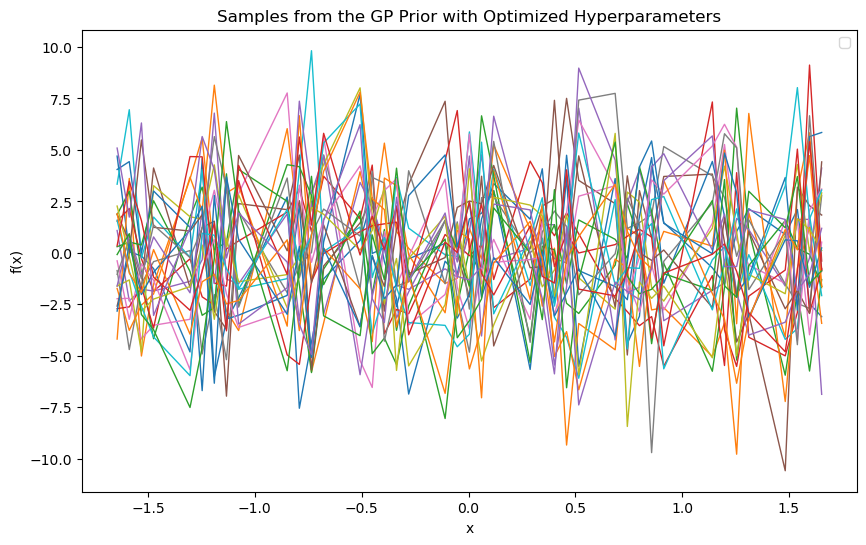

In [91]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.figure(figsize=(10, 6))
#plt.plot(X_train3.T[0], y_train3, 'kx', mew=2, label='Training points')
for i in range(num_samples):
    plt.plot(X_train3.T[0], f_prior_optimized[:, i], lw=1)
plt.title('Samples from the GP Prior with Optimized Hyperparameters')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

In [92]:
X_obs = X_train3
y_obs = y_train3

# Compute covariance matrices for predictions
K_obs = rbf_kernel2(X_obs, X_obs, optimized_length_scale, optimized_variance)
K_s = rbf_kernel2(X_obs, X_obs, optimized_length_scale, optimized_variance)
K_ss = rbf_kernel2(X_obs, X_obs, optimized_length_scale, optimized_variance)
K_obs_inv = np.linalg.inv(K_obs + noise * np.eye(len(X_obs)))

# Compute the mean and covariance of the posterior
mu_s = np.dot(K_s, np.dot(K_obs_inv, y_obs))
cov_s = K_ss - np.dot(K_s, np.dot(K_obs_inv, K_s.T))

# Sample from the posterior
np.random.seed(112)
L_post = cholesky(cov_s + noise * np.eye(len(X_obs)), lower=True)
f_post = mu_s.reshape(-1, 1) + np.dot(L_post, np.random.normal(size=(len(X_obs), num_samples)))

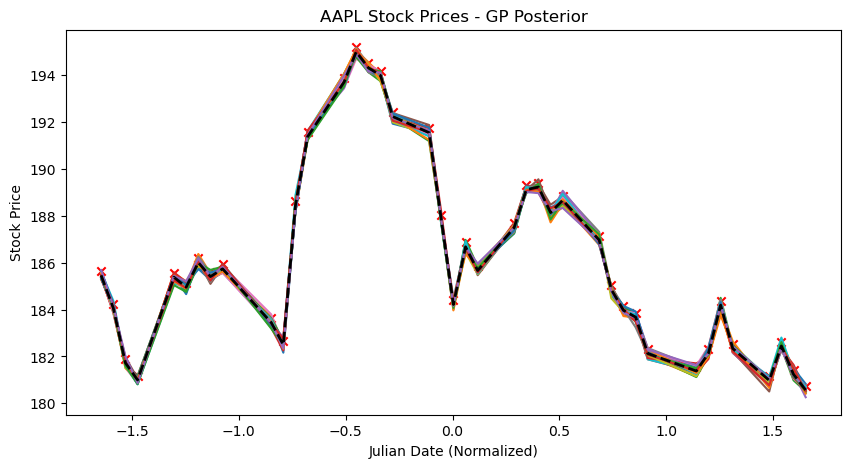

In [93]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Plot samples from the posterior
plt.figure(figsize=(10, 5))
plt.plot(X_train3.T[0], f_post, label="Posterior Samples")
plt.scatter(X_train3.T[0], y_obs, c='red', marker='x', label="Observed Data")
plt.plot(X_train3.T[0], mu_s, 'k--', lw=2, label="Posterior Mean")
plt.fill_between(X_train3.T[0].flatten(), 
                 mu_s.flatten() - 1.96 * np.sqrt(np.diag(cov_s)), 
                 mu_s.flatten() + 1.96 * np.sqrt(np.diag(cov_s)), 
                 alpha=0.2, label="95% Confidence Interval")
plt.title("AAPL Stock Prices - GP Posterior")
plt.xlabel("Julian Date (Normalized)")
plt.ylabel("Stock Price")
#plt.legend()
plt.show()

In [94]:
# Compute the covariance vector between the new date and observed dates
K_new = rbf_kernel2(X_test2, X_obs, optimized_length_scale, optimized_variance)
K_new_new = rbf_kernel2(X_test2, X_test2, optimized_length_scale, optimized_variance)

# Compute the mean and variance of the posterior at the new date
mu_new = np.dot(K_new, np.dot(K_obs_inv, y_obs))
cov_new = K_new_new - np.dot(K_new, np.dot(K_obs_inv, K_new.T))

# Compute the standard deviation
sigma_new = np.sqrt(cov_new)

# Print the predicted means and standard deviations
for i in range(len(X_test2.T[0])):
    print(f"Predicted mean at new date {X_test2.T[0][i]}: {mu_new[i]}")
    print(f"Predicted standard deviation at new date {X_test2.T[0][i]}: {sigma_new[i]}")

Predicted mean at new date 1.709919092555762: 180.56943056943058
Predicted standard deviation at new date 1.709919092555762: [0.09995004 0.09995004 0.33240289 0.33240289 0.10045104]
Predicted mean at new date 1.8804949631029608: 180.56943056943058
Predicted standard deviation at new date 1.8804949631029608: [0.09995004 0.09995004 0.09995004 0.09995004        nan]
Predicted mean at new date 1.9373535866186937: 180.56943056943058
Predicted standard deviation at new date 1.9373535866186937: [0.33240289 0.09995004 0.09995004 0.09995004        nan]
Predicted mean at new date 1.9942122101344268: 180.56943056943058
Predicted standard deviation at new date 1.9942122101344268: [0.33240289 0.09995004 0.09995004 0.09995004        nan]
Predicted mean at new date 2.0510708336501597: 182.38418351694645
Predicted standard deviation at new date 2.0510708336501597: [0.10045104        nan        nan        nan        nan]


C:\Users\aman1\AppData\Local\Temp\ipykernel_18112\1086388962.py:10: RuntimeWarning: invalid value encountered in sqrt
  sigma_new = np.sqrt(cov_new)
